In [1]:
# import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# import the demographic data
demographic_data = pd.read_csv('funcs/tsv/master_participants_list.tsv', sep='\t')
# Map the sex column to a categorical variable
demographic_data['sex'] = demographic_data['sex'].map({'M': 'Male', 'F': 'Female'})

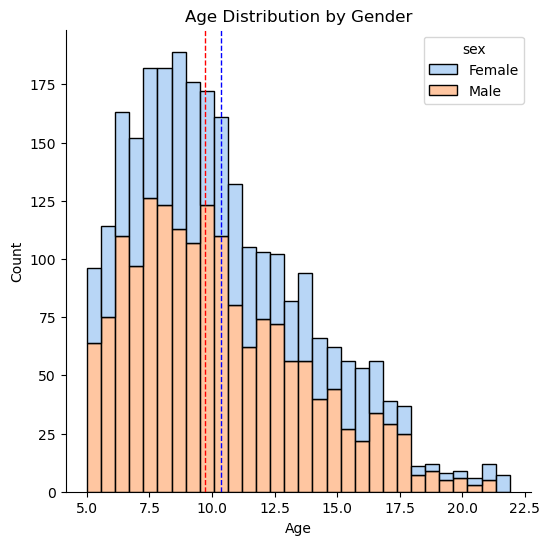

In [14]:
# Create a histogram with 'age' on the x-axis and 'sex' as hue
plt.figure(figsize=(6, 6))
sns.histplot(data=demographic_data, x='age', hue='sex', multiple='stack',bins=30, palette='pastel')
# plot mean and median age
plt.axvline(demographic_data['age'].mean(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(demographic_data['age'].median(), color='red', linestyle='dashed', linewidth=1)

plt.title('Age Distribution by Gender')
plt.xlabel('Age')
plt.ylabel('Count')
sns.despine()
# save the plot as pdf
# plt.savefig('funcs/age_distribution.pdf')
plt.show()

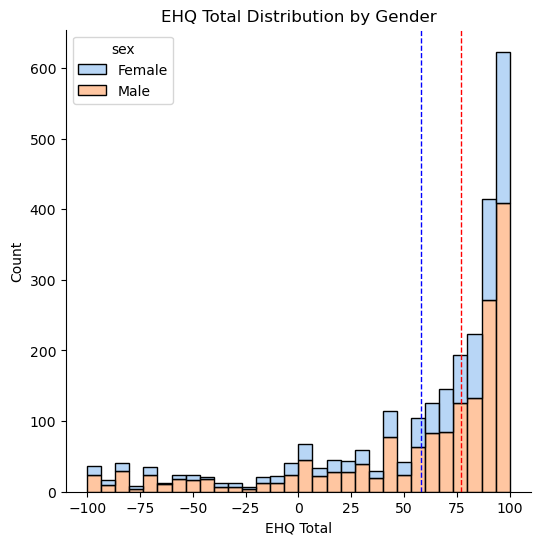

In [15]:
# Add histogram for ehq_total with gender as hue
plt.figure(figsize=(6, 6))
sns.histplot(data=demographic_data, x='ehq_total', hue='sex', multiple='stack',bins=30, palette='pastel')
# plot mean and median ehq_total
plt.axvline(demographic_data['ehq_total'].mean(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(demographic_data['ehq_total'].median(), color='red', linestyle='dashed', linewidth=1)

plt.title('EHQ Total Distribution by Gender')
plt.xlabel('EHQ Total')
plt.ylabel('Count')
sns.despine()
# save the plot as pdf
# plt.savefig('funcs/ehq_total_distribution.pdf')
plt.show()

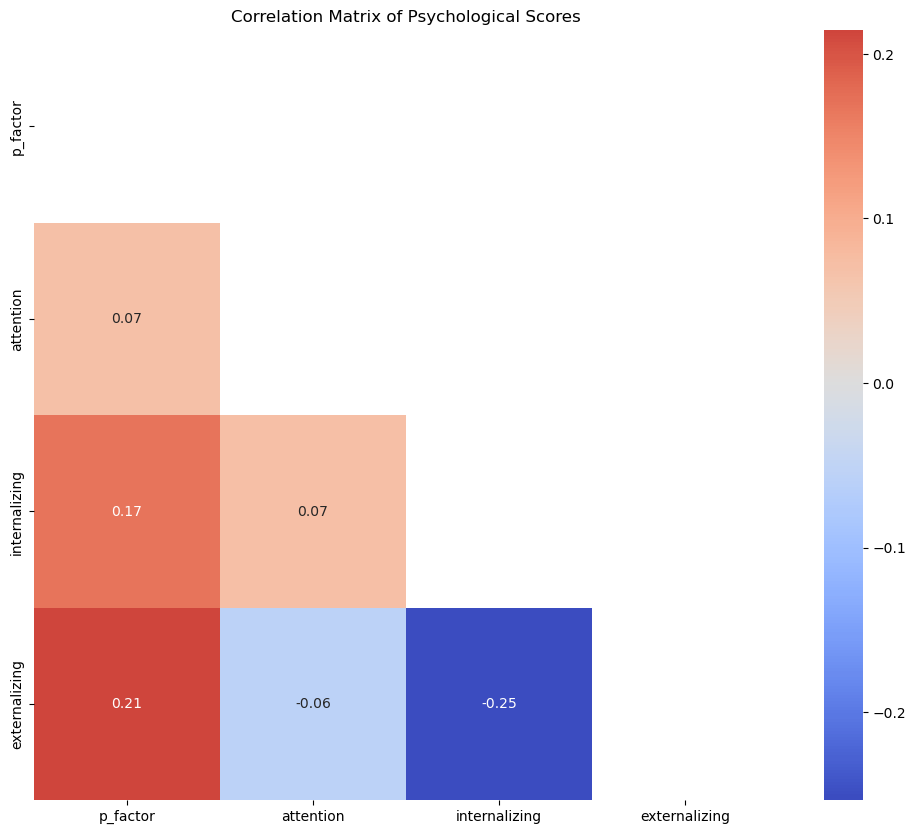

In [5]:
# Select relevant columns
selected_data = demographic_data[['p_factor', 'attention', 'internalizing', 'externalizing']]

# Compute the correlation matrix
corr_matrix = selected_data.corr()

# Create a mask to hide the upper triangle and diagonal
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create a heatmap
plt.figure(figsize=(12, 10))  # Increase figure size
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, annot_kws={"size": 10}, mask=mask)
plt.title('Correlation Matrix of Psychological Scores')
# save the plot as pdf
# plt.savefig('funcs/correlation_matrix.pdf')
plt.show()


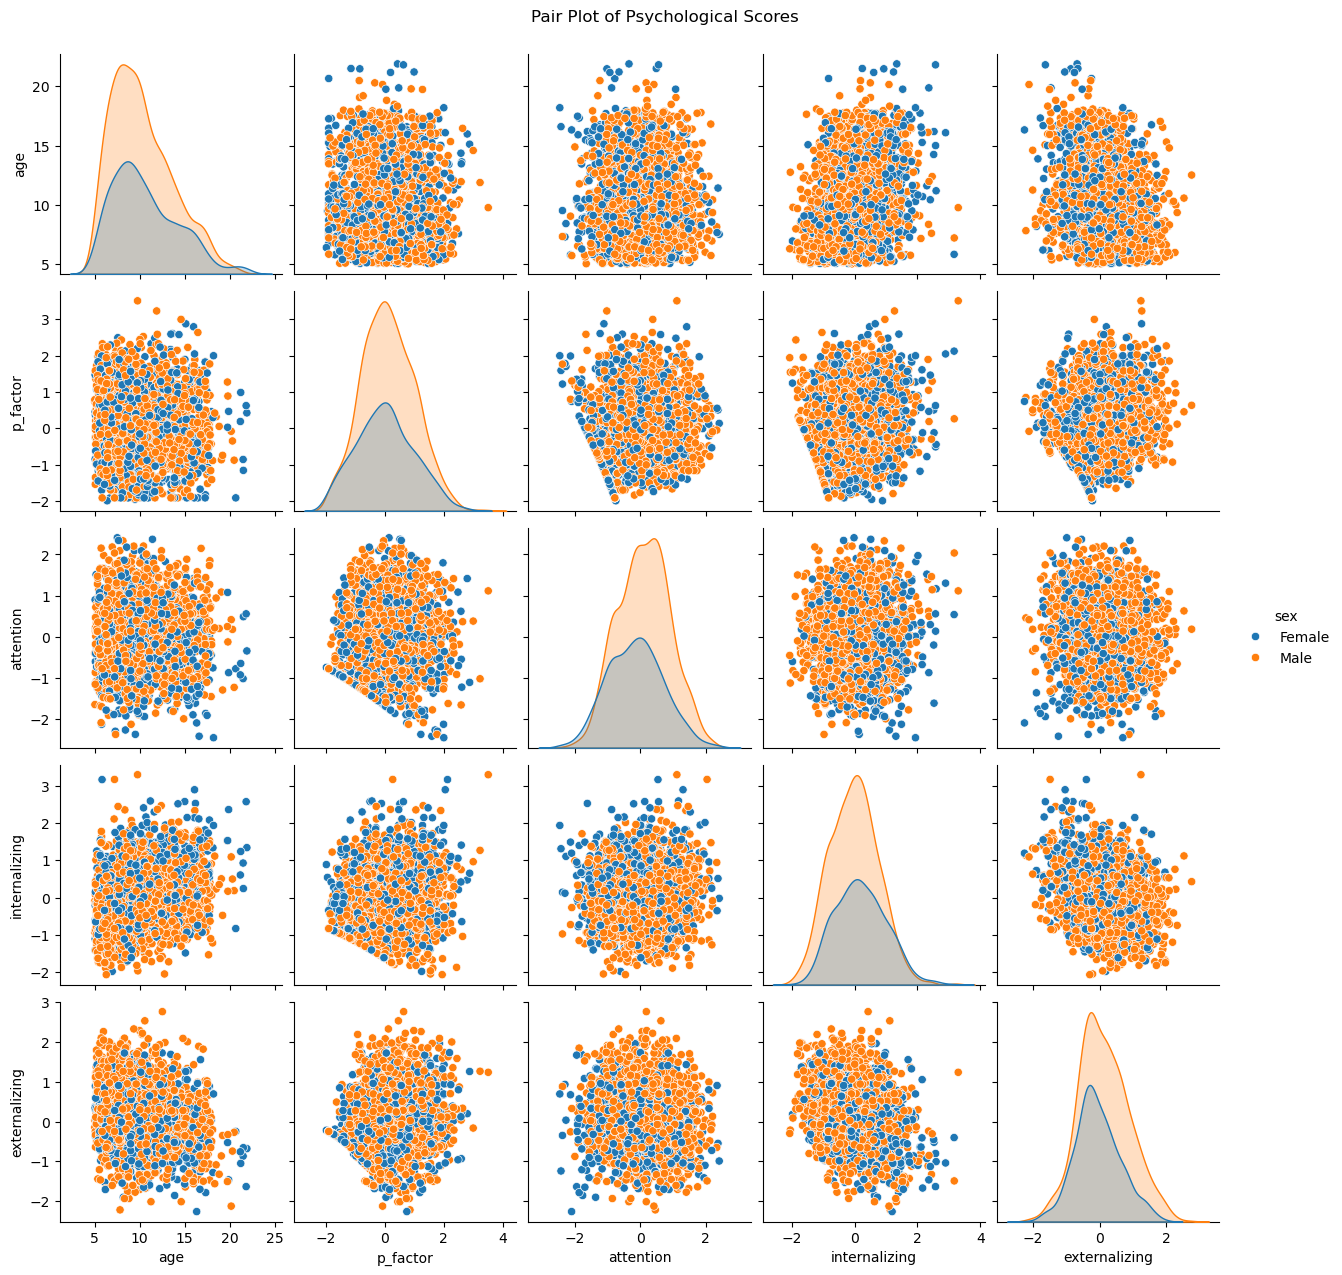

In [6]:
sns.pairplot(demographic_data, vars=['age', 'p_factor', 'attention', 'internalizing', 'externalizing'], hue='sex', diag_kind='kde')
plt.suptitle('Pair Plot of Psychological Scores', y=1.02)
# save the plot as pdf
# plt.savefig('funcs/pair_plot.pdf')
plt.show()